### Model Continuous data

Since continuous features show most impact we try generate data for missing data instead of replacing with median value. First we try with age and later for spend columns if it presents useful results.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score,\
ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import pickle

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_full = pd.concat([df_train, df_test], axis=0)

In [3]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.5+ MB


Let's drop Transported column and rows with all missing values.

In [4]:
df_full = df_full.drop(columns=["Transported", "PassengerId", "Name"])
df_full = df_full.dropna(axis=0)
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10119 entries, 0 to 4276
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    10119 non-null  object 
 1   CryoSleep     10119 non-null  object 
 2   Cabin         10119 non-null  object 
 3   Destination   10119 non-null  object 
 4   Age           10119 non-null  float64
 5   VIP           10119 non-null  object 
 6   RoomService   10119 non-null  float64
 7   FoodCourt     10119 non-null  float64
 8   ShoppingMall  10119 non-null  float64
 9   Spa           10119 non-null  float64
 10  VRDeck        10119 non-null  float64
dtypes: float64(6), object(5)
memory usage: 948.7+ KB


In [5]:
df_full.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0


### Now we perform transformation of Cryo Sleep and VIP to binary, also create Deck and Side feature

In [6]:
df_full["CryoSleep"] = df_full["CryoSleep"].astype(int)
df_full['VIP'] = df_full["VIP"].astype(int)
df_full.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,Europa,0,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0
1,Earth,0,F/0/S,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0
2,Europa,0,A/0/S,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0
3,Europa,0,A/0/S,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0
4,Earth,0,F/1/S,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0


In [7]:
def find_value(row, pos):
    try:
        return str(row).split("/")[pos]
    except IndexError:
        return None

df_full["Deck"] = df_full["Cabin"].apply(lambda x: find_value(x, 0))  
df_full["Side"] = df_full["Cabin"].apply(lambda x: find_value(x, 2))  

df_full.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Side
0,Europa,0,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,B,P
1,Earth,0,F/0/S,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,F,S
2,Europa,0,A/0/S,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,A,S
3,Europa,0,A/0/S,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,A,S
4,Earth,0,F/1/S,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,F,S


In [8]:
df_full = df_full.drop(columns="Cabin", axis=1)
df_full["Destination"] = df_full["Destination"].replace("TRAPPIST-1e", "TRAPPIST").replace("55 Cancri e", "Cancri").replace("PSO J318.5-22", "PSO")
df_full.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Side
0,Europa,0,TRAPPIST,39.0,0,0.0,0.0,0.0,0.0,0.0,B,P
1,Earth,0,TRAPPIST,24.0,0,109.0,9.0,25.0,549.0,44.0,F,S
2,Europa,0,TRAPPIST,58.0,1,43.0,3576.0,0.0,6715.0,49.0,A,S
3,Europa,0,TRAPPIST,33.0,0,0.0,1283.0,371.0,3329.0,193.0,A,S
4,Earth,0,TRAPPIST,16.0,0,303.0,70.0,151.0,565.0,2.0,F,S


#### Now we can apply dummy variables to categorical features

In [9]:
df_full_enc = pd.get_dummies(df_full, columns=["HomePlanet", "Destination", "Deck", "Side"], drop_first=False)
df_full_enc.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1,...,0,1,0,0,0,0,0,0,1,0
1,0,24.0,0,109.0,9.0,25.0,549.0,44.0,1,0,...,0,0,0,0,0,1,0,0,0,1
2,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,1,...,1,0,0,0,0,0,0,0,0,1
3,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,1,...,1,0,0,0,0,0,0,0,0,1
4,0,16.0,0,303.0,70.0,151.0,565.0,2.0,1,0,...,0,0,0,0,0,1,0,0,0,1


Let's scale the data for better estimation

In [10]:
columns_to_scale = ['Age','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit the scaler to the selected columns
scaler.fit(df_full_enc[columns_to_scale])

# Transform the selected columns
scaled_columns = scaler.transform(df_full_enc[columns_to_scale])

# Create a copy of the original data and replace the scaled columns with the scaled values
df_full_enc[columns_to_scale] = scaled_columns
df_full_enc.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,0,0.708529,0,-0.349392,-0.288375,-0.290101,-0.275058,-0.265118,0,1,...,0,1,0,0,0,0,0,0,1,0
1,0,-0.333181,0,-0.178286,-0.282798,-0.249515,0.213688,-0.226464,1,0,...,0,0,0,0,0,1,0,0,0,1
2,0,2.028027,1,-0.281891,1.927495,-0.290101,5.702956,-0.222072,0,1,...,1,0,0,0,0,0,0,0,0,1
3,0,0.291845,0,-0.349392,0.506637,0.312186,2.688577,-0.095569,0,1,...,1,0,0,0,0,0,0,0,0,1
4,0,-0.888759,0,0.126249,-0.244999,-0.044965,0.227932,-0.263361,1,0,...,0,0,0,0,0,1,0,0,0,1


### Outliers

In [11]:
def outliers_define(col, df):
    percentile25 = df_full_enc[col].quantile(0.25)
    percentile75 = df_full_enc[col].quantile(0.75)

    iqr = percentile75 - percentile25

    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    print("Upper limit", upper_limit)
    print("Lower limit", lower_limit)

    outlier = df[(df[col] > upper_limit) | (df[col] < lower_limit)]

    print(f"Number of outliers in the {col} section", len(outlier))
    df = df[(df[col] < upper_limit) & (df[col] > lower_limit)]
    outlier = df[(df[col] > upper_limit) | (df[col] < lower_limit)]
    print(f"Number of outliers in the {col} section", len(outlier))
    return df

df_full_enc = outliers_define("Age", df_full_enc)
df_full_enc.info()

Upper limit 2.618329162706857
Lower limit -2.659665368517663
Number of outliers in the Age section 91
Number of outliers in the Age section 0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10028 entries, 0 to 4276
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CryoSleep             10028 non-null  int64  
 1   Age                   10028 non-null  float64
 2   VIP                   10028 non-null  int64  
 3   RoomService           10028 non-null  float64
 4   FoodCourt             10028 non-null  float64
 5   ShoppingMall          10028 non-null  float64
 6   Spa                   10028 non-null  float64
 7   VRDeck                10028 non-null  float64
 8   HomePlanet_Earth      10028 non-null  uint8  
 9   HomePlanet_Europa     10028 non-null  uint8  
 10  HomePlanet_Mars       10028 non-null  uint8  
 11  Destination_Cancri    10028 non-null  uint8  
 12  Destination_PSO       10028 non

We have 23 features and 1 target feature that we will try to estimate

## Construct phase for Age feature

In [187]:
X_age = df_full_enc.drop(columns="Age", axis=1)
y_age = df_full_enc["Age"]

y_age.describe()

count    10028.000000
mean        -0.026631
std          0.964244
min         -1.999916
25%         -0.680417
50%         -0.159563
75%          0.569634
max          2.583606
Name: Age, dtype: float64

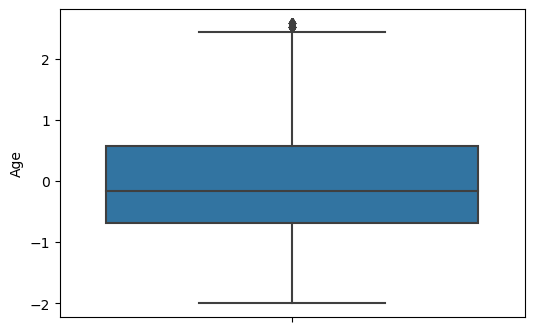

In [188]:
plt.figure(figsize=(6, 4))  
sns.boxplot(y = y_age)

plt.ylabel("Age")  

plt.show()

In [189]:
X_data, X_test, y_data, y_test = train_test_split(X_age, y_age, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.25, random_state=42)
print(y_test.shape, y_val.shape, y_train.shape)

(2006,) (2006,) (6016,)


### Random Forest Regressor

In [190]:
rf_reg = RandomForestRegressor(random_state=42)

cv_params = {'max_depth': [3,5, None], 
             'max_features': [7,15,23],
             'max_samples': [0.05, 0.1, 0.3],
             'min_samples_leaf': [3, 5, 7],
             'min_samples_split': [2, 3, 4],
             'n_estimators': [100, 300, 500],
             }  

scoring = {'neg_mean_squared_error', 'neg_root_mean_squared_error', 'r2'}

rf_cv = GridSearchCV(rf_reg, cv_params, scoring=scoring, cv=5, refit='neg_mean_squared_error')

In [191]:
%%time
rf_cv.fit(X_train, y_train)

CPU times: user 17min 10s, sys: 5.6 s, total: 17min 15s
Wall time: 17min 16s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [3, 5, None], 'max_features': [7, 15, 23],
                         'max_samples': [0.05, 0.1, 0.3],
                         'min_samples_leaf': [3, 5, 7],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [100, 300, 500]},
             refit='neg_mean_squared_error',
             scoring={'neg_mean_squared_error', 'neg_root_mean_squared_error',
                      'r2'})

In [17]:
def make_results(model_name: str, model_object, metric: str, X, y):
    '''
    Arguments:
        model_name (string): What you want the model to be called in the output table.
        model_object: A fit GridSearchCV object.
        metric (string): MSE, RMSE, or R2.
        X: Input data for evaluation.
        y: Target labels for evaluation.
  
    Returns a pandas DataFrame with the MSE, RMSE, MAE, and R2 scores
    for the model with the best mean 'metric' score across all validation folds.  
    '''

    # Create dictionary that maps input metric to scorer function in GridSearchCV
    metric_dict = {
        "MAE": 'neg_mean_absolute_error',
        'MSE': 'neg_mean_squared_error',
        'RMSE': 'neg_mean_squared_error',
        'R2': 'r2',
    }

    # Get the scorer function for the specified metric
    scorer = model_object.scorer_[metric_dict[metric]]

    # Get the best estimator from GridSearchCV
    best_estimator = model_object.best_estimator_

    # Fit the best estimator on the entire dataset
    best_estimator.fit(X, y)

    # Calculate the MAE score
    mae = -scorer(best_estimator, X, y)

    # Calculate other scores using the best estimator
    mse = -best_estimator.score(X, y)
    rmse = np.sqrt(-mse)
    r2 = best_estimator.score(X, y)

    # Create DataFrame of results
    table = pd.DataFrame({
        'Model': [model_name],
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
    })
  
    return table


In [193]:
rf_table = make_results("Random Forest Regressor", rf_cv, "RMSE", X_val, y_val)
rf_table

,Model,MSE,MAE,RMSE,R2
0,Random Forest Regressor,-0.259255,0.669287,0.509171,0.259255


In [18]:
def get_scores(model_name:str, model, X_test_data, y_test_data):
    '''
    Generate a table of test scores.

    In: 
        model_name (string):  How you want your model to be named in the output table
        model:                A fit GridSearchCV object
        X_test_data:          numpy array of X_test data
        y_test_data:          numpy array of y_test data

    Out: pandas df of precision, recall, f1, accuracy, and AUC scores for your model
    '''

    preds = model.best_estimator_.predict(X_test_data)

    mae = round(mean_absolute_error(y_test_data, preds), 3)
    mse = round(mean_squared_error(y_test_data, preds), 3)
    rmse = round(mean_squared_error(y_test_data, preds, squared=False), 3)
    r2 = round(r2_score(y_test_data, preds), 3)


    table = pd.DataFrame({'model': [model_name],
                        'MAE': [mae],
                        'MSE': [mse], 
                        'RMSE': [rmse],
                        'R2': [r2],
                        })
  
    return table

In [196]:
rf_score = get_scores("Random Forest Regressor", rf_cv, X_test, y_test)
rf_score

,model,MAE,MSE,RMSE,R2
0,Random Forest Regressor,0.7,0.779,0.883,0.164


### XGBoost Regressor

In [197]:
xgb_reg = XGBRegressor(random_state=42)

cv_params_xgb = {
    "max_depth": [3, 6, 9, 12],
    "min_child_weight": [3, 5, 7, 9],
    "learning_rate": [0.001, 0.01, 0.1],
    "n_estimators": [100, 300, 500]
} 

scoring = {'neg_mean_squared_error', 'neg_root_mean_squared_error', 'r2'}

xgb_cv = GridSearchCV(xgb_reg, cv_params_xgb, scoring=scoring, cv=5, refit='neg_mean_squared_error')


In [198]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: user 1h 39s, sys: 4min 35s, total: 1h 5min 15s
Wall time: 6min 38s


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42,
                                    reg_alpha=None, reg_lambda=None, ...),
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [3, 6, 9, 12],
                         'min_child_weight': [3, 5, 7, 9],
                         'n_estimators': [100, 300, 500]},
             refit='neg_mean_squared_error',
             scoring={'neg_mean_squared_error', 'neg_root_mean_squared_error',
                      'r2'})

In [199]:
xgb_table = make_results("RXGBoost Regressor", xgb_cv, "RMSE", X_val, y_val)
xgb_table

,Model,MSE,MAE,RMSE,R2
0,RXGBoost Regressor,-0.344952,0.591857,0.587326,0.344952


In [200]:
xgb_score = get_scores("XGBoost Regressor", xgb_cv, X_test, y_test)
xgb_score

,model,MAE,MSE,RMSE,R2
0,XGBoost Regressor,0.705,0.786,0.887,0.157


In [201]:
score_table = pd.concat([rf_score, xgb_score])
score_table

,model,MAE,MSE,RMSE,R2
0,Random Forest Regressor,0.700,0.779,0.883,0.164
0,XGBoost Regressor,0.705,0.786,0.887,0.157


In [22]:
def write_pickle(path, model_object, save_as:str):
    '''
    In: 
        path:         path of folder where you want to save the pickle
        model_object: a model you want to pickle
        save_as:      filename for how you want to save the model

    Out: A call to pickle the model in the folder indicated
    '''    

    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [203]:
write_pickle("", rf_cv.best_estimator_, 'model_age')

### Construct phase for Room Service

In [204]:
X_rs = df_full_enc.drop(columns="RoomService", axis=1)
y_rs = df_full_enc["RoomService"]

y_rs.describe()

count    10028.000000
mean        -0.003066
std          0.988719
min         -0.349392
25%         -0.349392
50%         -0.349392
75%         -0.269333
max         17.808169
Name: RoomService, dtype: float64

In [205]:
X_data, X_test, y_data, y_test = train_test_split(X_rs, y_rs, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.25, random_state=42)
print(y_test.shape, y_val.shape, y_train.shape)

(2006,) (2006,) (6016,)


In [206]:
rf_reg = RandomForestRegressor(random_state=42)

cv_params = {'max_depth': [3,5, None], 
             'max_features': [7,15,23],
             'max_samples': [0.05, 0.1, 0.3],
             'min_samples_leaf': [3, 5, 7],
             'min_samples_split': [2, 3, 4],
             'n_estimators': [100, 300, 500],
             }  

scoring = {'neg_mean_squared_error', 'neg_root_mean_squared_error', 'r2'}

rf_cv = GridSearchCV(rf_reg, cv_params, scoring=scoring, cv=5, refit='neg_mean_squared_error')

In [207]:
%%time
rf_cv.fit(X_train, y_train)

CPU times: user 17min 15s, sys: 6.47 s, total: 17min 21s
Wall time: 22min 8s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [3, 5, None], 'max_features': [7, 15, 23],
                         'max_samples': [0.05, 0.1, 0.3],
                         'min_samples_leaf': [3, 5, 7],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [100, 300, 500]},
             refit='neg_mean_squared_error',
             scoring={'neg_mean_squared_error', 'neg_root_mean_squared_error',
                      'r2'})

In [208]:
rf_table_rs = make_results("Random Forest Regressor rs", rf_cv, "RMSE", X_val, y_val)
rf_table_rs

,Model,MSE,MAE,RMSE,R2
0,Random Forest Regressor rs,-0.468228,0.463763,0.684272,0.468228


In [209]:
rf_score_rs = get_scores("Random Forest Regressor rs", rf_cv, X_test, y_test)
rf_score_rs

,model,MAE,MSE,RMSE,R2
0,Random Forest Regressor rs,0.322,1.032,1.016,0.263


In [210]:
write_pickle("", rf_cv.best_estimator_, 'model_room_service')

### Construct for Food Court

In [12]:
X_fc = df_full_enc.drop(columns="FoodCourt", axis=1)
y_fc = df_full_enc["FoodCourt"]

y_fc.describe()

count    10028.000000
mean        -0.000714
std          0.998054
min         -0.288375
25%         -0.288375
50%         -0.288375
75%         -0.238183
max         18.185257
Name: FoodCourt, dtype: float64

In [13]:
X_data, X_test, y_data, y_test = train_test_split(X_fc, y_fc, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.25, random_state=42)
print(y_test.shape, y_val.shape, y_train.shape)

(2006,) (2006,) (6016,)


In [14]:
rf_reg = RandomForestRegressor(random_state=42)

cv_params = {'max_depth': [3,5, None], 
             'max_features': [7,15,23],
             'max_samples': [0.05, 0.1, 0.3],
             'min_samples_leaf': [3, 5, 7],
             'min_samples_split': [2, 3, 4],
             'n_estimators': [100, 300, 500],
             }  

scoring = {'neg_mean_squared_error', 'neg_root_mean_squared_error', 'r2'}

rf_cv_fc = GridSearchCV(rf_reg, cv_params, scoring=scoring, cv=5, refit='neg_mean_squared_error')

In [15]:
%%time
rf_cv_fc.fit(X_train, y_train)

CPU times: user 17min, sys: 3.99 s, total: 17min 4s
Wall time: 1h 18min 59s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [3, 5, None], 'max_features': [7, 15, 23],
                         'max_samples': [0.05, 0.1, 0.3],
                         'min_samples_leaf': [3, 5, 7],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [100, 300, 500]},
             refit='neg_mean_squared_error',
             scoring={'neg_mean_squared_error', 'neg_root_mean_squared_error',
                      'r2'})

In [19]:
rf_table_fc = make_results("Random Forest Regressor rs", rf_cv_fc, "RMSE", X_val, y_val)
rf_table_fc

,Model,MSE,MAE,RMSE,R2
0,Random Forest Regressor rs,-0.529589,0.702112,0.727729,0.529589


In [20]:
rf_score_fc = get_scores("Random Forest Regressor rs", rf_cv_fc, X_test, y_test)
rf_score_fc

,model,MAE,MSE,RMSE,R2
0,Random Forest Regressor rs,0.24,0.544,0.738,0.391


In [23]:
write_pickle("", rf_cv_fc.best_estimator_, 'model_food_court')

### Construct Shopping Mall

In [24]:
X_sm = df_full_enc.drop(columns="ShoppingMall", axis=1)
y_sm = df_full_enc["ShoppingMall"]

y_sm.describe()

count    10028.000000
mean        -0.000037
std          1.002417
min         -0.290101
25%         -0.290101
50%         -0.290101
75%         -0.243022
max         37.847131
Name: ShoppingMall, dtype: float64

In [25]:
X_data, X_test, y_data, y_test = train_test_split(X_sm, y_sm, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.25, random_state=42)
print(y_test.shape, y_val.shape, y_train.shape)

(2006,) (2006,) (6016,)


In [26]:
rf_cv_sm = GridSearchCV(rf_reg, cv_params, scoring=scoring, cv=5, refit='neg_mean_squared_error')

In [27]:
%%time
rf_cv_sm.fit(X_train, y_train)

CPU times: user 17min 19s, sys: 8.41 s, total: 17min 27s
Wall time: 18min 8s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [3, 5, None], 'max_features': [7, 15, 23],
                         'max_samples': [0.05, 0.1, 0.3],
                         'min_samples_leaf': [3, 5, 7],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [100, 300, 500]},
             refit='neg_mean_squared_error',
             scoring={'neg_mean_squared_error', 'neg_root_mean_squared_error',
                      'r2'})

In [28]:
rf_table_sm = make_results("Random Forest Regressor rs", rf_cv_sm, "RMSE", X_val, y_val)
rf_table_sm

,Model,MSE,MAE,RMSE,R2
0,Random Forest Regressor rs,-0.356921,0.594364,0.597428,0.356921


In [29]:
rf_score_sm = get_scores("Random Forest Regressor rs", rf_cv_sm, X_test, y_test)
rf_score_sm

,model,MAE,MSE,RMSE,R2
0,Random Forest Regressor rs,0.309,0.689,0.83,0.183


In [30]:
write_pickle("", rf_cv_sm.best_estimator_, 'model_shopping_mall')

### Construct Spa

In [31]:
X_sp = df_full_enc.drop(columns="Spa", axis=1)
y_sp = df_full_enc["Spa"]

y_sp.describe()

count    10028.000000
mean        -0.005144
std          0.969908
min         -0.275058
25%         -0.275058
50%         -0.275058
75%         -0.222533
max         16.258625
Name: Spa, dtype: float64

In [34]:
X_data, X_test, y_data, y_test = train_test_split(X_sp, y_sp, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.25, random_state=42)
print(y_test.shape, y_val.shape, y_train.shape)

(2006,) (2006,) (6016,)


In [35]:
%%time
rf_cv_sp = GridSearchCV(rf_reg, cv_params, scoring=scoring, cv=5, refit='neg_mean_squared_error')
rf_cv_sp.fit(X_train, y_train)

CPU times: user 17min 4s, sys: 5.57 s, total: 17min 9s
Wall time: 36min 58s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [3, 5, None], 'max_features': [7, 15, 23],
                         'max_samples': [0.05, 0.1, 0.3],
                         'min_samples_leaf': [3, 5, 7],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [100, 300, 500]},
             refit='neg_mean_squared_error',
             scoring={'neg_mean_squared_error', 'neg_root_mean_squared_error',
                      'r2'})

In [36]:
rf_table_sp = make_results("Random Forest Regressor rs", rf_cv_sp, "RMSE", X_val, y_val)
rf_table_sp

,Model,MSE,MAE,RMSE,R2
0,Random Forest Regressor rs,-0.36223,0.552711,0.601855,0.36223


In [37]:
rf_score_sp = get_scores("Random Forest Regressor rs", rf_cv_sp, X_test, y_test)
rf_score_sp

,model,MAE,MSE,RMSE,R2
0,Random Forest Regressor rs,0.247,0.613,0.783,0.261


In [38]:
write_pickle("", rf_cv_sp.best_estimator_, 'model_spa')

### Construct VR Deck

In [40]:
X_vr = df_full_enc.drop(columns="VRDeck", axis=1)
y_vr = df_full_enc["VRDeck"]

y_sp.describe()

count    10028.000000
mean        -0.005144
std          0.969908
min         -0.275058
25%         -0.275058
50%         -0.275058
75%         -0.222533
max         16.258625
Name: Spa, dtype: float64

In [41]:
X_data, X_test, y_data, y_test = train_test_split(X_vr, y_vr, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.25, random_state=42)
print(y_test.shape, y_val.shape, y_train.shape)

(2006,) (2006,) (6016,)


In [42]:
%%time
rf_cv_vr = GridSearchCV(rf_reg, cv_params, scoring=scoring, cv=5, refit='neg_mean_squared_error')
rf_cv_vr.fit(X_train, y_train)

CPU times: user 17min 21s, sys: 7.44 s, total: 17min 28s
Wall time: 19min 11s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [3, 5, None], 'max_features': [7, 15, 23],
                         'max_samples': [0.05, 0.1, 0.3],
                         'min_samples_leaf': [3, 5, 7],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [100, 300, 500]},
             refit='neg_mean_squared_error',
             scoring={'neg_mean_squared_error', 'neg_root_mean_squared_error',
                      'r2'})

In [43]:
rf_table_vr = make_results("Random Forest Regressor rs", rf_cv_vr, "RMSE", X_val, y_val)
rf_table_vr

,Model,MSE,MAE,RMSE,R2
0,Random Forest Regressor rs,-0.40855,0.629658,0.639179,0.40855


In [44]:
rf_score_vr = get_scores("Random Forest Regressor rs", rf_cv_vr, X_test, y_test)
rf_score_vr

,model,MAE,MSE,RMSE,R2
0,Random Forest Regressor rs,0.266,0.741,0.861,0.238


In [45]:
write_pickle("", rf_cv_vr.best_estimator_, 'model_vr_deck')

## Let's try to predict categorical variable

In [97]:
df_full_cat = pd.get_dummies(df_full, columns=["Destination", "Deck", "Side"], drop_first=False)
df_full_cat.head()

,HomePlanet,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Destination_Cancri,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,Europa,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,...,0,1,0,0,0,0,0,0,1,0
1,Earth,0,24.0,0,109.0,9.0,25.0,549.0,44.0,0,...,0,0,0,0,0,1,0,0,0,1
2,Europa,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,...,1,0,0,0,0,0,0,0,0,1
3,Europa,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,...,1,0,0,0,0,0,0,0,0,1
4,Earth,0,16.0,0,303.0,70.0,151.0,565.0,2.0,0,...,0,0,0,0,0,1,0,0,0,1


In [98]:
columns_to_scale = ['Age','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit the scaler to the selected columns
scaler.fit(df_full_cat[columns_to_scale])

# Transform the selected columns
scaled_columns = scaler.transform(df_full_cat[columns_to_scale])

# Create a copy of the original data and replace the scaled columns with the scaled values
df_full_cat[columns_to_scale] = scaled_columns
df_full_cat.head()

,HomePlanet,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Destination_Cancri,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,Europa,0,0.708529,0,-0.349392,-0.288375,-0.290101,-0.275058,-0.265118,0,...,0,1,0,0,0,0,0,0,1,0
1,Earth,0,-0.333181,0,-0.178286,-0.282798,-0.249515,0.213688,-0.226464,0,...,0,0,0,0,0,1,0,0,0,1
2,Europa,0,2.028027,1,-0.281891,1.927495,-0.290101,5.702956,-0.222072,0,...,1,0,0,0,0,0,0,0,0,1
3,Europa,0,0.291845,0,-0.349392,0.506637,0.312186,2.688577,-0.095569,0,...,1,0,0,0,0,0,0,0,0,1
4,Earth,0,-0.888759,0,0.126249,-0.244999,-0.044965,0.227932,-0.263361,0,...,0,0,0,0,0,1,0,0,0,1


In [99]:
df_full_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10119 entries, 0 to 4276
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HomePlanet            10119 non-null  object 
 1   CryoSleep             10119 non-null  int64  
 2   Age                   10119 non-null  float64
 3   VIP                   10119 non-null  int64  
 4   RoomService           10119 non-null  float64
 5   FoodCourt             10119 non-null  float64
 6   ShoppingMall          10119 non-null  float64
 7   Spa                   10119 non-null  float64
 8   VRDeck                10119 non-null  float64
 9   Destination_Cancri    10119 non-null  uint8  
 10  Destination_PSO       10119 non-null  uint8  
 11  Destination_TRAPPIST  10119 non-null  uint8  
 12  Deck_A                10119 non-null  uint8  
 13  Deck_B                10119 non-null  uint8  
 14  Deck_C                10119 non-null  uint8  
 15  Deck_D              

In [103]:
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
y = df_full_cat["HomePlanet"]
label_encoder.fit(y)
y=label_encoder.transform(y)
classes=label_encoder.classes_

In [104]:
X = df_full_cat.drop(columns=["HomePlanet"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(y_test.shape, y_train.shape)

(2530,) (7589,)


In [105]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,auc

In [106]:
RF=OneVsRestClassifier(RandomForestClassifier(max_features=21))
RF.fit(X_train,y_train)
y_pred =RF.predict(X_test)
pred_prob = RF.predict_proba(X_test)

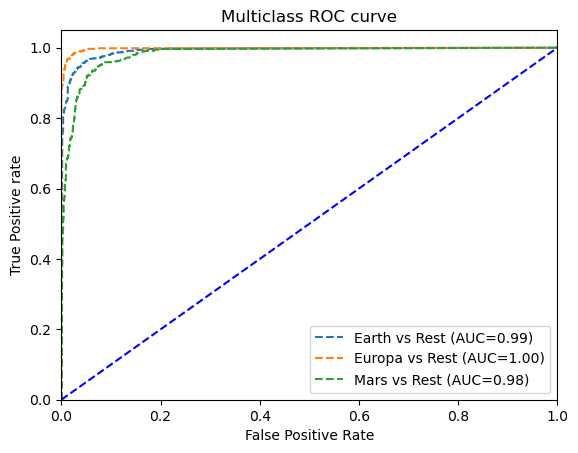

In [107]:
from sklearn.preprocessing import label_binarize
#binarize the y_values

y_test_binarized=label_binarize(y_test,classes=np.unique(y_test))

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()

n_class = classes.shape[0]

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], pred_prob[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # plotting    
    plt.plot(fpr[i], tpr[i], linestyle='--', 
             label='%s vs Rest (AUC=%0.2f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()

In [118]:
write_pickle("", RF, 'model_home_planet')

## Next we explore the column Destination

In [120]:
df_full_cat = pd.get_dummies(df_full, columns=["HomePlanet", "Deck", "Side"], drop_first=False)
df_full_cat.head()

,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,0,TRAPPIST,39.0,0,0.0,0.0,0.0,0.0,0.0,0,...,0,1,0,0,0,0,0,0,1,0
1,0,TRAPPIST,24.0,0,109.0,9.0,25.0,549.0,44.0,1,...,0,0,0,0,0,1,0,0,0,1
2,0,TRAPPIST,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,...,1,0,0,0,0,0,0,0,0,1
3,0,TRAPPIST,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,...,1,0,0,0,0,0,0,0,0,1
4,0,TRAPPIST,16.0,0,303.0,70.0,151.0,565.0,2.0,1,...,0,0,0,0,0,1,0,0,0,1


In [121]:
columns_to_scale = ['Age','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit the scaler to the selected columns
scaler.fit(df_full_cat[columns_to_scale])

# Transform the selected columns
scaled_columns = scaler.transform(df_full_cat[columns_to_scale])

# Create a copy of the original data and replace the scaled columns with the scaled values
df_full_cat[columns_to_scale] = scaled_columns
df_full_cat.head()

,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,0,TRAPPIST,0.708529,0,-0.349392,-0.288375,-0.290101,-0.275058,-0.265118,0,...,0,1,0,0,0,0,0,0,1,0
1,0,TRAPPIST,-0.333181,0,-0.178286,-0.282798,-0.249515,0.213688,-0.226464,1,...,0,0,0,0,0,1,0,0,0,1
2,0,TRAPPIST,2.028027,1,-0.281891,1.927495,-0.290101,5.702956,-0.222072,0,...,1,0,0,0,0,0,0,0,0,1
3,0,TRAPPIST,0.291845,0,-0.349392,0.506637,0.312186,2.688577,-0.095569,0,...,1,0,0,0,0,0,0,0,0,1
4,0,TRAPPIST,-0.888759,0,0.126249,-0.244999,-0.044965,0.227932,-0.263361,1,...,0,0,0,0,0,1,0,0,0,1


In [122]:
label_encoder=LabelEncoder()
y = df_full_cat["Destination"]
label_encoder.fit(y)
y=label_encoder.transform(y)
classes=label_encoder.classes_

In [123]:
X = df_full_cat.drop(columns=["Destination"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(y_test.shape, y_train.shape)

(2530,) (7589,)


In [166]:
RF_dest=OneVsRestClassifier(RandomForestClassifier(max_features=8, n_estimators=150, max_depth=7, min_samples_leaf=2))
RF_dest.fit(X_train,y_train)
y_pred =RF_dest.predict(X_test)
pred_prob = RF_dest.predict_proba(X_test)

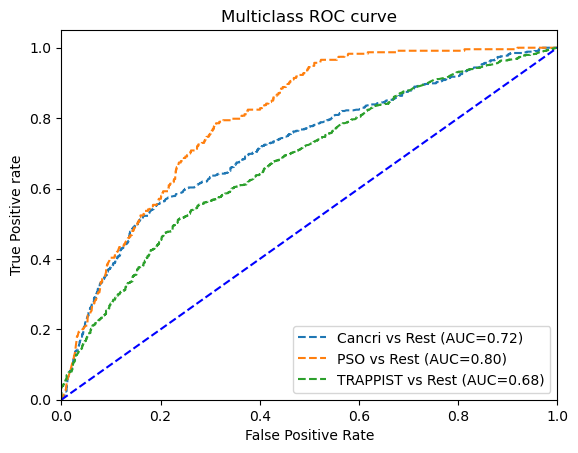

In [167]:
y_test_binarized=label_binarize(y_test,classes=np.unique(y_test))

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()

n_class = classes.shape[0]

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], pred_prob[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # plotting    
    plt.plot(fpr[i], tpr[i], linestyle='--', 
             label='%s vs Rest (AUC=%0.2f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()

In [168]:
write_pickle("", RF_dest, 'model_destination')

## Next Model Deck

In [169]:
df_full_cat = pd.get_dummies(df_full, columns=["HomePlanet", "Destination", "Side"], drop_first=False)
df_full_cat.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_Cancri,Destination_PSO,Destination_TRAPPIST,Side_P,Side_S
0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,B,0,1,0,0,0,1,1,0
1,0,24.0,0,109.0,9.0,25.0,549.0,44.0,F,1,0,0,0,0,1,0,1
2,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,A,0,1,0,0,0,1,0,1
3,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,A,0,1,0,0,0,1,0,1
4,0,16.0,0,303.0,70.0,151.0,565.0,2.0,F,1,0,0,0,0,1,0,1


In [170]:
columns_to_scale = ['Age','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit the scaler to the selected columns
scaler.fit(df_full_cat[columns_to_scale])

# Transform the selected columns
scaled_columns = scaler.transform(df_full_cat[columns_to_scale])

# Create a copy of the original data and replace the scaled columns with the scaled values
df_full_cat[columns_to_scale] = scaled_columns
df_full_cat.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_Cancri,Destination_PSO,Destination_TRAPPIST,Side_P,Side_S
0,0,0.708529,0,-0.349392,-0.288375,-0.290101,-0.275058,-0.265118,B,0,1,0,0,0,1,1,0
1,0,-0.333181,0,-0.178286,-0.282798,-0.249515,0.213688,-0.226464,F,1,0,0,0,0,1,0,1
2,0,2.028027,1,-0.281891,1.927495,-0.290101,5.702956,-0.222072,A,0,1,0,0,0,1,0,1
3,0,0.291845,0,-0.349392,0.506637,0.312186,2.688577,-0.095569,A,0,1,0,0,0,1,0,1
4,0,-0.888759,0,0.126249,-0.244999,-0.044965,0.227932,-0.263361,F,1,0,0,0,0,1,0,1


In [171]:
label_encoder=LabelEncoder()
y = df_full_cat["Deck"]
label_encoder.fit(y)
y=label_encoder.transform(y)
classes=label_encoder.classes_

In [172]:
X = df_full_cat.drop(columns=["Deck"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(y_test.shape, y_train.shape)

(2530,) (7589,)


In [192]:
RF_deck=OneVsRestClassifier(RandomForestClassifier(max_features=5, n_estimators=150, max_depth=4, min_samples_leaf=2))
RF_deck.fit(X_train,y_train)
y_pred =RF_deck.predict(X_test)
pred_prob = RF_deck.predict_proba(X_test)

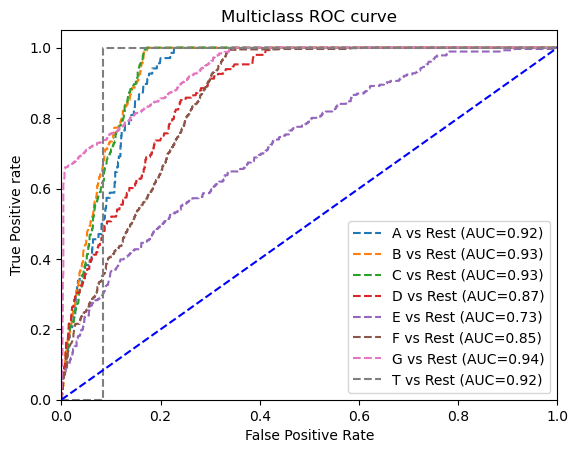

In [193]:
y_test_binarized=label_binarize(y_test,classes=np.unique(y_test))

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()

n_class = classes.shape[0]

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], pred_prob[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # plotting    
    plt.plot(fpr[i], tpr[i], linestyle='--', 
             label='%s vs Rest (AUC=%0.2f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()

In [194]:
write_pickle("", RF_deck, 'model_deck')

## Side column

In [195]:
df_full_cat = pd.get_dummies(df_full, columns=["HomePlanet", "Destination", "Deck"], drop_first=False)
df_full_cat.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Side,HomePlanet_Earth,...,Destination_PSO,Destination_TRAPPIST,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T
0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,P,0,...,0,1,0,1,0,0,0,0,0,0
1,0,24.0,0,109.0,9.0,25.0,549.0,44.0,S,1,...,0,1,0,0,0,0,0,1,0,0
2,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,S,0,...,0,1,1,0,0,0,0,0,0,0
3,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,S,0,...,0,1,1,0,0,0,0,0,0,0
4,0,16.0,0,303.0,70.0,151.0,565.0,2.0,S,1,...,0,1,0,0,0,0,0,1,0,0


In [196]:
columns_to_scale = ['Age','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit the scaler to the selected columns
scaler.fit(df_full_cat[columns_to_scale])

# Transform the selected columns
scaled_columns = scaler.transform(df_full_cat[columns_to_scale])

# Create a copy of the original data and replace the scaled columns with the scaled values
df_full_cat[columns_to_scale] = scaled_columns
df_full_cat.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Side,HomePlanet_Earth,...,Destination_PSO,Destination_TRAPPIST,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T
0,0,0.708529,0,-0.349392,-0.288375,-0.290101,-0.275058,-0.265118,P,0,...,0,1,0,1,0,0,0,0,0,0
1,0,-0.333181,0,-0.178286,-0.282798,-0.249515,0.213688,-0.226464,S,1,...,0,1,0,0,0,0,0,1,0,0
2,0,2.028027,1,-0.281891,1.927495,-0.290101,5.702956,-0.222072,S,0,...,0,1,1,0,0,0,0,0,0,0
3,0,0.291845,0,-0.349392,0.506637,0.312186,2.688577,-0.095569,S,0,...,0,1,1,0,0,0,0,0,0,0
4,0,-0.888759,0,0.126249,-0.244999,-0.044965,0.227932,-0.263361,S,1,...,0,1,0,0,0,0,0,1,0,0


In [197]:
label_encoder=LabelEncoder()
y = df_full_cat["Side"]
label_encoder.fit(y)
y=label_encoder.transform(y)
classes=label_encoder.classes_

In [198]:
X = df_full_cat.drop(columns=["Side"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(y_test.shape, y_train.shape)

(2530,) (7589,)


In [221]:
clf_rf = RandomForestClassifier(random_state=42)
cv_params = {'max_depth': [3, 8, None], 
             'max_features': [5, 10, 15, 20],
             'max_samples': [0.3, 0.5],
             'min_samples_leaf': [2, 5, 8],
             'min_samples_split': [2, ],
             'n_estimators': [50, 100, 150],
             }  

scoring = {'accuracy', 'precision', 'recall', 'f1'}
rf_cv_acc = GridSearchCV(clf_rf, cv_params, scoring=scoring, cv=5, refit='f1')

In [222]:
%%time
rf_cv_acc.fit(X_train, y_train)

CPU times: user 5min 15s, sys: 2.73 s, total: 5min 18s
Wall time: 5min 18s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 8, None],
                         'max_features': [5, 10, 15, 20],
                         'max_samples': [0.3, 0.5],
                         'min_samples_leaf': [2, 5, 8],
                         'min_samples_split': [2],
                         'n_estimators': [50, 100, 150]},
             refit='f1', scoring={'f1', 'precision', 'recall', 'accuracy'})

In [223]:
def get_scores(model_name:str, model, X_test_data, y_test_data):
    '''
    Generate a table of test scores.

    In: 
        model_name (string):  How you want your model to be named in the output table
        model:                A fit GridSearchCV object
        X_test_data:          numpy array of X_test data
        y_test_data:          numpy array of y_test data

    Out: pandas df of precision, recall, f1, accuracy, and AUC scores for your model
    '''

    preds = model.best_estimator_.predict(X_test_data)

    auc = round(roc_auc_score(y_test_data, preds), 3)
    accuracy = round(accuracy_score(y_test_data, preds), 3)
    precision = round(precision_score(y_test_data, preds), 3)
    recall = round(recall_score(y_test_data, preds), 3)
    f1 = round(f1_score(y_test_data, preds), 3)

    table = pd.DataFrame({'model': [model_name],
                        'AUC': [auc],
                        'precision': [precision], 
                        'recall': [recall],
                        'f1': [f1],
                        'accuracy': [accuracy]
                        })
  
    return table

In [224]:
rf_score_acc = get_scores("Random Forest Classifier accuracy", rf_cv_acc, X_test, y_test)
rf_score_acc

,model,AUC,precision,recall,f1,accuracy
0,Random Forest Classifier accuracy,0.504,0.501,0.626,0.556,0.504


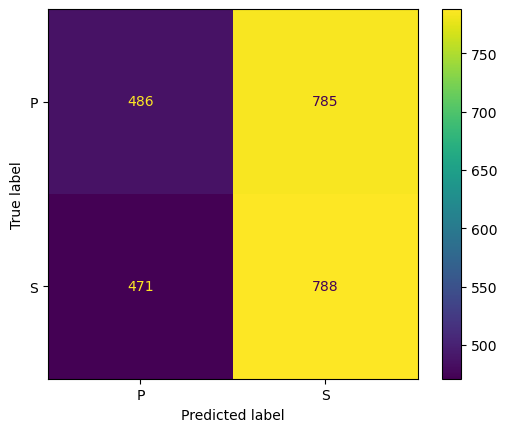

In [225]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_matrix(model, y_test, y_pred):
    log_cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

    # Create display of confusion matrix
    log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=classes)

    # Plot confusion matrix
    log_disp.plot()

    # Display plot
    plt.show()
    
plot_matrix(rf_cv_acc.best_estimator_, y_test, rf_cv_acc.best_estimator_.predict(X_test))

In [226]:
rf_cv_acc.best_params_

{'max_depth': 3,
 'max_features': 15,
 'max_samples': 0.5,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 50}

In [227]:
write_pickle("", rf_cv_acc.best_estimator_, 'model_side')

## CryoSleep column

In [228]:
df_full_cat = pd.get_dummies(df_full, columns=["HomePlanet", "Destination", "Deck", "Side"], drop_first=False)
df_full_cat.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1,...,0,1,0,0,0,0,0,0,1,0
1,0,24.0,0,109.0,9.0,25.0,549.0,44.0,1,0,...,0,0,0,0,0,1,0,0,0,1
2,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,1,...,1,0,0,0,0,0,0,0,0,1
3,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,1,...,1,0,0,0,0,0,0,0,0,1
4,0,16.0,0,303.0,70.0,151.0,565.0,2.0,1,0,...,0,0,0,0,0,1,0,0,0,1


In [229]:
columns_to_scale = ['Age','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit the scaler to the selected columns
scaler.fit(df_full_cat[columns_to_scale])

# Transform the selected columns
scaled_columns = scaler.transform(df_full_cat[columns_to_scale])

# Create a copy of the original data and replace the scaled columns with the scaled values
df_full_cat[columns_to_scale] = scaled_columns
df_full_cat.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,0,0.708529,0,-0.349392,-0.288375,-0.290101,-0.275058,-0.265118,0,1,...,0,1,0,0,0,0,0,0,1,0
1,0,-0.333181,0,-0.178286,-0.282798,-0.249515,0.213688,-0.226464,1,0,...,0,0,0,0,0,1,0,0,0,1
2,0,2.028027,1,-0.281891,1.927495,-0.290101,5.702956,-0.222072,0,1,...,1,0,0,0,0,0,0,0,0,1
3,0,0.291845,0,-0.349392,0.506637,0.312186,2.688577,-0.095569,0,1,...,1,0,0,0,0,0,0,0,0,1
4,0,-0.888759,0,0.126249,-0.244999,-0.044965,0.227932,-0.263361,1,0,...,0,0,0,0,0,1,0,0,0,1


In [230]:
y = df_full_cat["CryoSleep"]
X = df_full_cat.drop(columns=["CryoSleep"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(y_test.shape, y_train.shape)

(2530,) (7589,)


In [231]:
clf_rf = RandomForestClassifier(random_state=42)
cv_params = {'max_depth': [3, 8, None], 
             'max_features': [5, 10, 15, 20],
             'max_samples': [0.3, 0.5],
             'min_samples_leaf': [2, 5, 8],
             'min_samples_split': [2, ],
             'n_estimators': [100, 200, 300],
             }  

scoring = {'accuracy', 'precision', 'recall', 'f1'}
rf_cv_acc = GridSearchCV(clf_rf, cv_params, scoring=scoring, cv=5, refit='f1')

In [232]:
%%time
rf_cv_acc.fit(X_train, y_train)

CPU times: user 5min 38s, sys: 3.34 s, total: 5min 41s
Wall time: 5min 41s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 8, None],
                         'max_features': [5, 10, 15, 20],
                         'max_samples': [0.3, 0.5],
                         'min_samples_leaf': [2, 5, 8],
                         'min_samples_split': [2],
                         'n_estimators': [100, 200, 300]},
             refit='f1', scoring={'f1', 'precision', 'recall', 'accuracy'})

In [233]:
rf_score_acc = get_scores("Random Forest Classifier accuracy", rf_cv_acc, X_test, y_test)
rf_score_acc

,model,AUC,precision,recall,f1,accuracy
0,Random Forest Classifier accuracy,0.948,0.929,0.936,0.932,0.951


In [234]:
y.value_counts()

0    6493
1    3626
Name: CryoSleep, dtype: int64

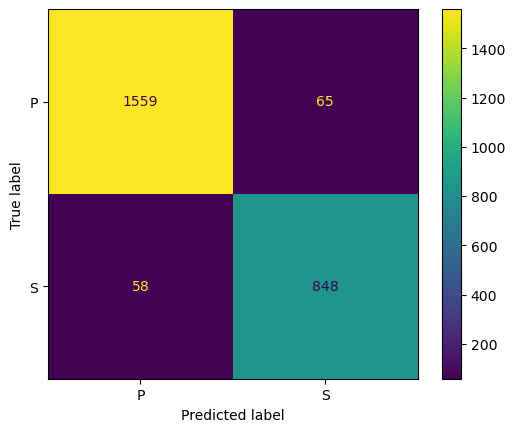

In [235]:
plot_matrix(rf_cv_acc.best_estimator_, y_test, rf_cv_acc.best_estimator_.predict(X_test))

In [236]:
write_pickle("", rf_cv_acc.best_estimator_, 'model_cryosleep')

## VIP column

In [237]:
y = df_full_cat["VIP"]
X = df_full_cat.drop(columns=["VIP"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(y_test.shape, y_train.shape)

(2530,) (7589,)


In [267]:
clf_rf = RandomForestClassifier(random_state=42)
cv_params = {
#     'max_depth': [3, 8, None], 
    'max_features': [5, 10, 15, 20],
#     'max_samples': [0.3, 0.5],
#     'min_samples_leaf': [2, 5, 8],
    'min_samples_split': [2, ],
    'n_estimators': [100, 200, 300],
             }  

scoring = {'accuracy', 'precision', 'recall', 'f1'}
rf_cv_acc = GridSearchCV(clf_rf, cv_params, scoring=scoring, cv=5, refit='f1')

In [268]:
%%time
rf_cv_acc.fit(X_train, y_train)

CPU times: user 45.1 s, sys: 361 ms, total: 45.5 s
Wall time: 45.5 s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_features': [5, 10, 15, 20],
                         'min_samples_split': [2],
                         'n_estimators': [100, 200, 300]},
             refit='f1', scoring={'f1', 'precision', 'recall', 'accuracy'})

In [269]:
rf_score_acc = get_scores("Random Forest Classifier accuracy", rf_cv_acc, X_test, y_test)
rf_score_acc

,model,AUC,precision,recall,f1,accuracy
0,Random Forest Classifier accuracy,0.508,0.333,0.017,0.033,0.977


In [270]:
y.value_counts()

0    9895
1     224
Name: VIP, dtype: int64

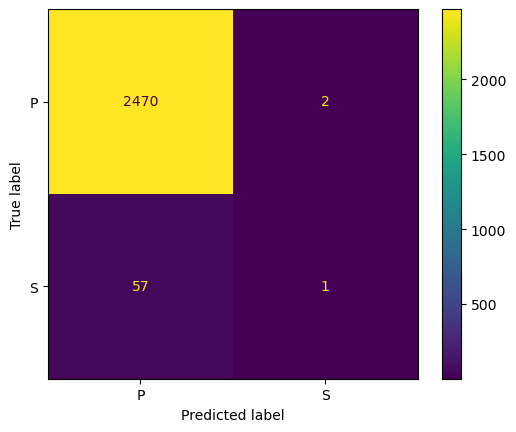

In [271]:
plot_matrix(rf_cv_acc.best_estimator_, y_test, rf_cv_acc.best_estimator_.predict(X_test))